In [1]:
pip install numpy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


# Simulations Project
## By Kaitlyn Zhou

### Introduction
Welcome to my simple simulations project! In this notebook, I will build the simulator and explain my thought process along the way.

### Initial Brainstorming and Testing
Based on the project spec, I decided that my first course of action would be to define what was given and turn them into variables. Using the variables I just defined and the useful formulas in the spec, I created functions. 

## Useful Formulas
actualF = min(appliedF, tractionF)

tractionF = μ*normalF = μmg

appliedF = motorF − resistanceF

τ = F∗r

v = ωr

x_f = x_i + v_i*t + 0.5*a_i*t^2

v_f = v_i + a*t

In [2]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Defining constants

mass = 300       # kg
tireRad = 0.254  # m
driveRatio = 4
timeStep = 0.5   # s
mu = 1
g = 9.81         # m/s^2
curveRad = 50    # m
torqueTable = pd.read_csv('motorCurves.csv')
rpmList = torqueTable['Motor Speed (RPM)'].values
torqueList = torqueTable['Torque (Capped at 80kW) (Nm)'].values

In [4]:
# Formula functions
def actualF(appliedF, tractionF):
    return min(appliedF, tractionF)

def tractionF():
    return mu*mass*g

def appliedF(motorF, resistanceF):
    return motorF-resistanceF

def motorF(torque):
    return (torque*driveRatio)/tireRad

def getTorque(v):
    wheelRPM = (v*60)/(2*np.pi*tireRad)
    motorRPM = wheelRPM*driveRatio
    torque = np.interp(motorRPM, rpmList, torqueList)
    return torque

In [5]:
# Simulation code
def sim():
    velocity = 0
    position = 0
    time = 0

    vLog = []
    tLog = []
    xLog = []
    torqueLog = []

    while position < 500:
        # Physics calculations
        torque = getTorque(velocity)
        mF = motorF(torque)
        apF = appliedF(mF, 0)
        trF = tractionF()
        actF = actualF(apF, trF)
        a = actF/mass

        # Add data to log
        vLog.append(velocity)
        tLog.append(time)
        xLog.append(position)
        torqueLog.append(torque)

        # Update movement
        position += velocity*timeStep + 0.5*a*timeStep**2
        velocity += a*timeStep
        time += timeStep
    print(time)
    return vLog, tLog, xLog, torqueLog

11.5


Text(0.5, 1.0, 'Velocity vs Time Graph')

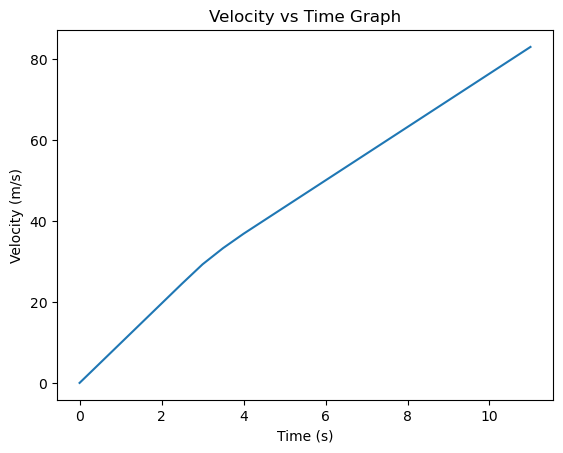

In [6]:
vData, tData, xData, torqueData = sim()
plt.plot(tData, vData)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity vs Time Graph")

Text(0.5, 1.0, 'Torque vs Time Graph')

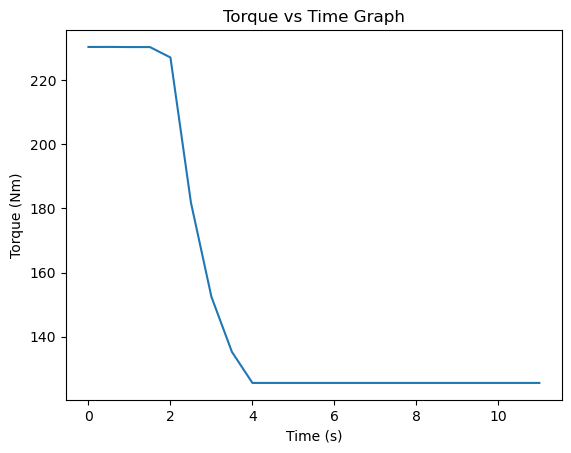

In [7]:
plt.plot(tData, torqueData)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.title("Torque vs Time Graph")

Text(0.5, 1.0, 'Position vs Time Graph')

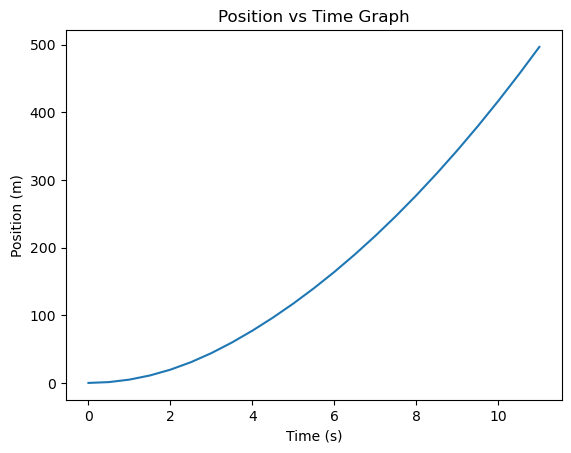

In [8]:
plt.plot(tData, xData)
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Position vs Time Graph")

In [9]:
'''def adjustedSim(v):
    torque = getTorque(v)
    mF = motorF(torque)
    apF = appliedF(mF, 0)
    trF = tractionF()
    actF = actualF(apF, trF)
    a = actF/mass

    stats = []
    stats.append(v)
    stats.append(t)
    stats.append(x)
    stats.append(torque)

    return stats

def jSim():
    velocity = 0
    position = 0
    time = 0

    vLog = []
    tLog = []
    xLog = []
    torqueLog = []
    
    while position < totalDist:
        if position < 500:
            vLog.append(adjustedSim(velocity, position, time)[0])
            tLog.append(adjustedSim(velocity, position, time)[1])
            xLog.append(adjustedSim(velocity, position, time)[2])
            torqueLog.append(adjustedSim(velocity, position, time)[3])
            # Update movement
            velocity += a*timeStep
            position += v*timeStep
            time += timeStep
        else:
            pass'''

# Initially I was going to compute each bend  of the track but I realized that the formula requires the minimum of the velocities that are resulted by the
# straight path, normal acceleration of the curve, and normal deceleration of the curve

'def adjustedSim(v):\n    torque = getTorque(v)\n    mF = motorF(torque)\n    apF = appliedF(mF, 0)\n    trF = tractionF()\n    actF = actualF(apF, trF)\n    a = actF/mass\n\n    stats = []\n    stats.append(v)\n    stats.append(t)\n    stats.append(x)\n    stats.append(torque)\n\n    return stats\n\ndef jSim():\n    velocity = 0\n    position = 0\n    time = 0\n\n    vLog = []\n    tLog = []\n    xLog = []\n    torqueLog = []\n\n    while position < totalDist:\n        if position < 500:\n            vLog.append(adjustedSim(velocity, position, time)[0])\n            tLog.append(adjustedSim(velocity, position, time)[1])\n            xLog.append(adjustedSim(velocity, position, time)[2])\n            torqueLog.append(adjustedSim(velocity, position, time)[3])\n            # Update movement\n            velocity += a*timeStep\n            position += v*timeStep\n            time += timeStep\n        else:\n            pass'

Text(0.5, 1.0, 'Final Velocity vs Time Graph')

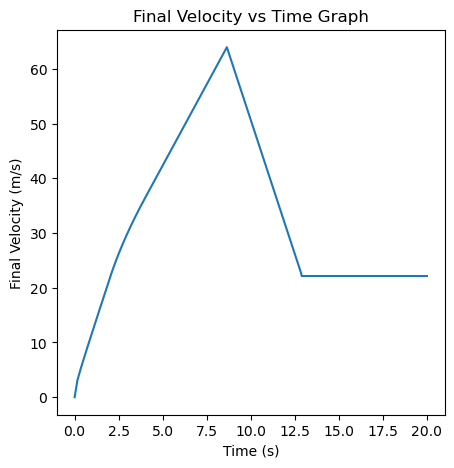

In [10]:
# Attempting the J-shaped track
totalDist = 500+(curveRad*np.pi)   # straight part + diameter of the curve
vMaxCurve = np.sqrt(g*curveRad)    # velocity from centripetal force
# ^ this is the max speed the car can go without veering off the curve

# New plan: 
'''
1. Create a table where each column corresponds to the velocity if under normal acceleration in straight line,
centripetal acceleration forward, centripetal decleration backward
2. Apply aggregate function over the columns to get the minimum velocity
3. Record results
'''
xStep = 0.5   # m
distances = np.arange(0, totalDist + xStep, xStep)
df = pd.DataFrame({'distance': distances})
def getForwardV():
    vForward = np.zeros(len(distances))
    v = 0
    for i in range(1, len(distances)):
        # Physics calculations
        torque = getTorque(v)
        motorForce = motorF(torque*0.9)   # 0.9 is the drivetrain efficiency
        a = min(motorForce, tractionF())/mass  # a is from f=ma
        v = np.sqrt(v**2 + 2*a*xStep)
        vForward[i] = v
    return vForward

def getBackwardV():
    vBackward = np.zeros(len(distances))
    v = vMaxCurve

    for i in range(len(distances)-1, -1, -1):
        if distances[i] > 500:
            v = vMaxCurve
        else:
            aBrake = g
            v = np.sqrt(v**2 + 2*aBrake*xStep)
        vBackward[i] = v
    return vBackward

df['motorVelocity'] = getForwardV()
df['brakeVelocity'] = getBackwardV()
df['maxApexVelocity'] = np.where(df['distance'] < 500, np.inf, vMaxCurve)
df['finalVelocity'] = df[['motorVelocity', 'brakeVelocity', 'maxApexVelocity']].min(axis=1)
df['timeStep'] = np.where(df['finalVelocity'] > 0, xStep/df['finalVelocity'], 0)
df.loc[0, 'timeStep'] = 0
df['time'] = df['timeStep'].cumsum()

plt.figure(figsize=(5,5))
plt.plot(df['time'], df['finalVelocity'])
plt.xlabel("Time (s)")
plt.ylabel("Final Velocity (m/s)")
plt.title("Final Velocity vs Time Graph")

In [11]:
df

,distance,motorVelocity,brakeVelocity,maxApexVelocity,finalVelocity,timeStep,time
0,0.0,0.000000,101.539697,inf,0.000000,0.000000,0.000000
1,0.5,3.132092,101.491379,inf,3.132092,0.159638,0.159638
2,1.0,4.429447,101.443038,inf,4.429447,0.112881,0.272519
3,1.5,5.424942,101.394674,inf,5.424942,0.092167,0.364686
4,2.0,6.264184,101.346288,inf,6.264184,0.079819,0.444504
...,...,...,...,...,...,...,...
1311,655.5,90.066481,22.147235,22.147235,22.147235,0.022576,19.911977
1312,656.0,90.099419,22.147235,22.147235,22.147235,0.022576,19.934553
1313,656.5,90.132345,22.147235,22.147235,22.147235,0.022576,19.957129
1314,657.0,90.165259,22.147235,22.147235,22.147235,0.022576,19.979706


Text(0.5, 1.0, 'Final Velocity vs Position Graph')

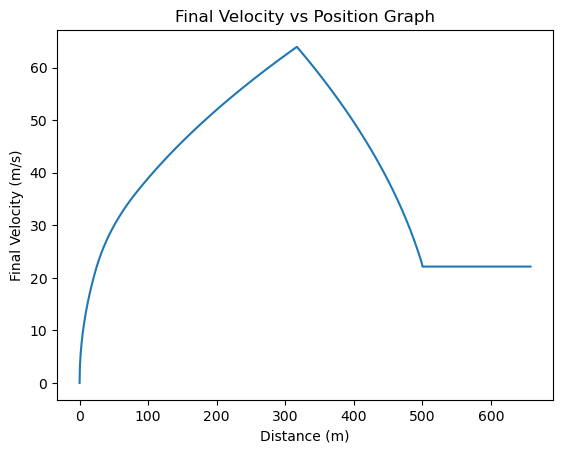

In [12]:
plt.plot(df['distance'], df['finalVelocity'])
plt.xlabel("Distance (m)")
plt.ylabel("Final Velocity (m/s)")
plt.title("Final Velocity vs Position Graph")

In [13]:
lapTime = df['time'].tolist()[len(df['time'])-1]
print("The lap time of the J-track is " + str(lapTime) + " seconds.")

The lap time of the J-track is 20.002281784891384 seconds.


Text(0.5, 1.0, 'Final Velocity vs Position Graph')

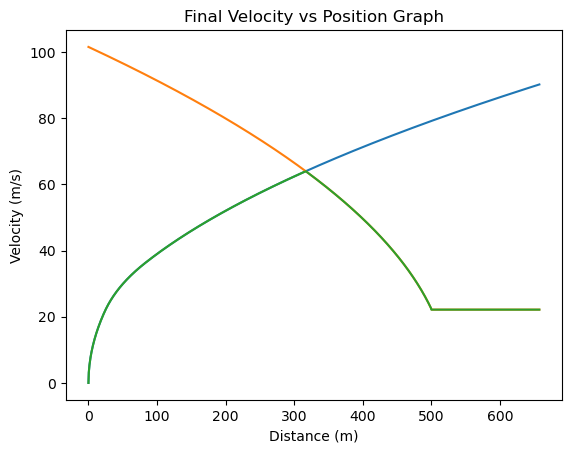

In [85]:
plt.plot(df['distance'], df['motorVelocity'])
plt.plot(df['distance'], df['brakeVelocity'])
plt.plot(df['distance'], df['finalVelocity'])
plt.xlabel("Distance (m)")
plt.ylabel("Velocity (m/s)")
plt.title("Final Velocity vs Position Graph")

## Extra Enhancements
I wanted to incorporate a little bit of what I am interested in into this project. Since we are applying our theoretical calculations to the real world, it is important that there is room for error to account for measurement issues or factors that cannot be calculated precisely. As a student studying statistics, I wanted to calculate the error using a bootstrap of the torque data since torque is the principal component behind driving the car forward. All other calculated parameters will rely on this component.

In [23]:
numSims = 100 # number of "runs" to perform
uncertainty = 0.05 # standard 5% uncertainty level

def sampTorque(v, uncertainty):
    # grab the value of torque
    baseTorque = getTorque(v)
    # generate a random value within the upper and lower bound of that torque
    lower = baseTorque*(1 - uncertainty)
    upper = baseTorque*(1 + uncertainty)
    estTorque = np.random.uniform(lower, upper)
    return estTorque

def singleRun(uncertainty):
    # simulates one run of the J-track
    # forward part uses torque
    vForward = np.zeros(len(distances))
    v = 0.001
    for i in range(1, len(distances)):
        # Physics calculations
        torque = sampTorque(v, uncertainty)
        motorForce = motorF(torque*0.9)   # 0.9 is the drivetrain efficiency
        a = min(motorForce, tractionF())/mass  # a is from f=ma
        v = np.sqrt(v**2 + 2*a*xStep)
        vForward[i] = v
    # backward part does not use torque
    vBackward = getBackwardV()
    # create array with max velocity at apex
    vMaxCurveArr = np.where(distances < 500, np.inf, vMaxCurve)
    # merge forward and backward velocities
    vFinal = np.minimum(np.minimum(vForward, vBackward), vMaxCurveArr)
    timeStep = np.where(vFinal > 0, xStep / vFinal, 0)
    totalTime = np.sum(timeStep)
    
    return vFinal, totalTime

allVelocities = []
allTimes = []

# doing many simulations to create distribution
for i in range(numSims):
    vProfile, timeLap = singleRun(uncertainty)
    allVelocities.append(vProfile)
    allTimes.append(timeLap)
    
allVelocities = np.array(allVelocities)

/tmp/ipykernel_75/755258550.py:31: RuntimeWarning: divide by zero encountered in divide
  timeStep = np.where(vFinal > 0, xStep / vFinal, 0)


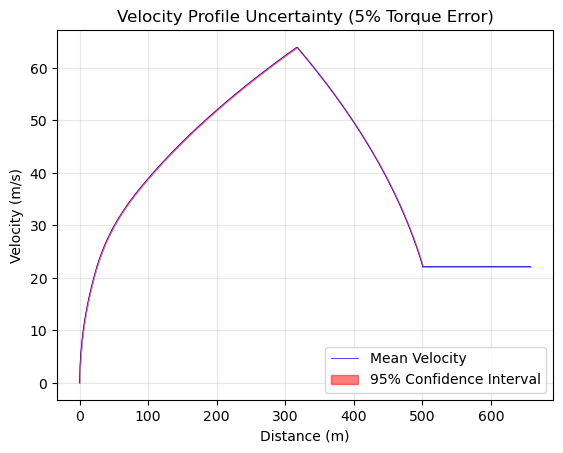

In [35]:
# calculating statistics across all runs
meanV = np.mean(allVelocities, axis = 0)
stdV = np.std(allVelocities, axis = 0)
upperV = np.percentile(allVelocities, 100*(1 - uncertainty / 2), axis = 0) 
lowerV = np.percentile(allVelocities, 100*(0 + uncertainty / 2), axis = 0)

# making the graph
plt.plot(distances, meanV, color='blue', label='Mean Velocity', linewidth=0.5)
plt.fill_between(distances, lowerV, upperV, color='red', alpha=0.5, label="95% Confidence Interval")
plt.title("Velocity Profile Uncertainty (5% Torque Error)")
plt.xlabel("Distance (m)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [28]:
meanTime = np.mean(allTimes)
stdTime = np.std(allTimes)

print("Theoretical Lap Time: " + str(meanTime) + "+/- " + str(stdTime) + ".")

Theoretical Lap Time: 20.002770369726033+/- 0.0033760168593757614.
